In [1]:
import random

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from tqdm.notebook import tqdm

PIL2torch = transforms.ToTensor()

In [2]:
class FaceFolderDataset(Dataset):
    def __init__(self, root_dir, dirs=None, image_size=(112, 112)):
        self.image_size = image_size
        self.root_dir = root_dir
        self.persons = sorted(os.listdir(root_dir))
        if dirs is not None:
            for p in self.persons:
                if p not in dirs:
                    self.persons.remove(p)
        self.person_images = {p: [] for p in self.persons}
        self.image_paths = []

        self.images_per_person = None
        for i, per in enumerate(self.persons):
            pearson_dir = self.person_dir(per)
            if self.images_per_person is None:
                self.images_per_person = len(os.listdir(pearson_dir))
            else:
                if self.images_per_person != len(os.listdir(pearson_dir)):
                    warnings.warn(f"Person {per} has different number of images than other persons")
            for file_name in os.listdir(pearson_dir):
                self.image_paths.append(os.path.join(pearson_dir, file_name))
                self.person_images[per].append(file_name)


    def person_dir(self, person: str)->str:
        if person in self.persons:
            return os.path.join(self.root_dir, person)
        else:
            raise ValueError(f"Person {person} not found in dataset")

    def __len__(self)->int:
        return len(self.image_paths)

    def __getitem__(self, idx: tuple[str, int] | str)->(Image.Image, str):
        """
        :param idx: tuple of (person, image_idx) of person images or person: str - to get random person image
        :return:
        """
        if type(idx) is tuple:
            person, id_ = idx
            image_path = os.path.join(self.root_dir, person,  self.person_images[person][id_])
            img = Image.open(image_path)
            img = img.convert("RGB")
            return img, person
        elif type(idx) is str or np.str_:
            person = idx
            image_path = os.path.join(self.root_dir, person, random.choice(self.person_images[person]))

            img = Image.open(image_path)
            img = img.convert("RGB")
            return img, person
        else:
            raise ValueError(f"idx must be tuple of (person, image_idx) or str, but got {type(idx)}")

In [3]:
class FaceDataLoader:
    def __init__(self, dataset, batch_size=32, number_of_batches=1000):
        self.dataset = dataset
        self.batch_size = batch_size
        self.number_of_batches = number_of_batches

    def __iter__(self)->torch.Tensor:
        for _ in range(self.number_of_batches):
            result = torch.Tensor(3 * self.batch_size, 3, *self.dataset.image_size)
            persons = np.array(random.sample(self.dataset.persons, 2 * self.batch_size)).reshape(-1, 2)
            for i in range(0, 3 * self.batch_size, 3):
                result[i] = PIL2torch(self.dataset[persons[i//3, 0]][0])
                result[i+1] = PIL2torch(self.dataset[persons[i//3, 0]][0])
                result[i+2] = PIL2torch(self.dataset[persons[i//3, 1]][0])
            yield result


    def __len__(self):
        return self.number_of_batches

In [31]:
test_dataset = FaceFolderDataset(root_dir="images", dirs=[str(i) for i in range(1, 41)])
train_dataset  = FaceFolderDataset(root_dir="images", dirs=[str(i) for i in range(41, 5999)])

test_dataloader = FaceDataLoader(test_dataset, batch_size=16)
train_dataloader = FaceDataLoader(train_dataset, batch_size=100)

torch.Size([3, 112, 112]) torch.Size([3, 112, 112]) torch.Size([3, 112, 112])


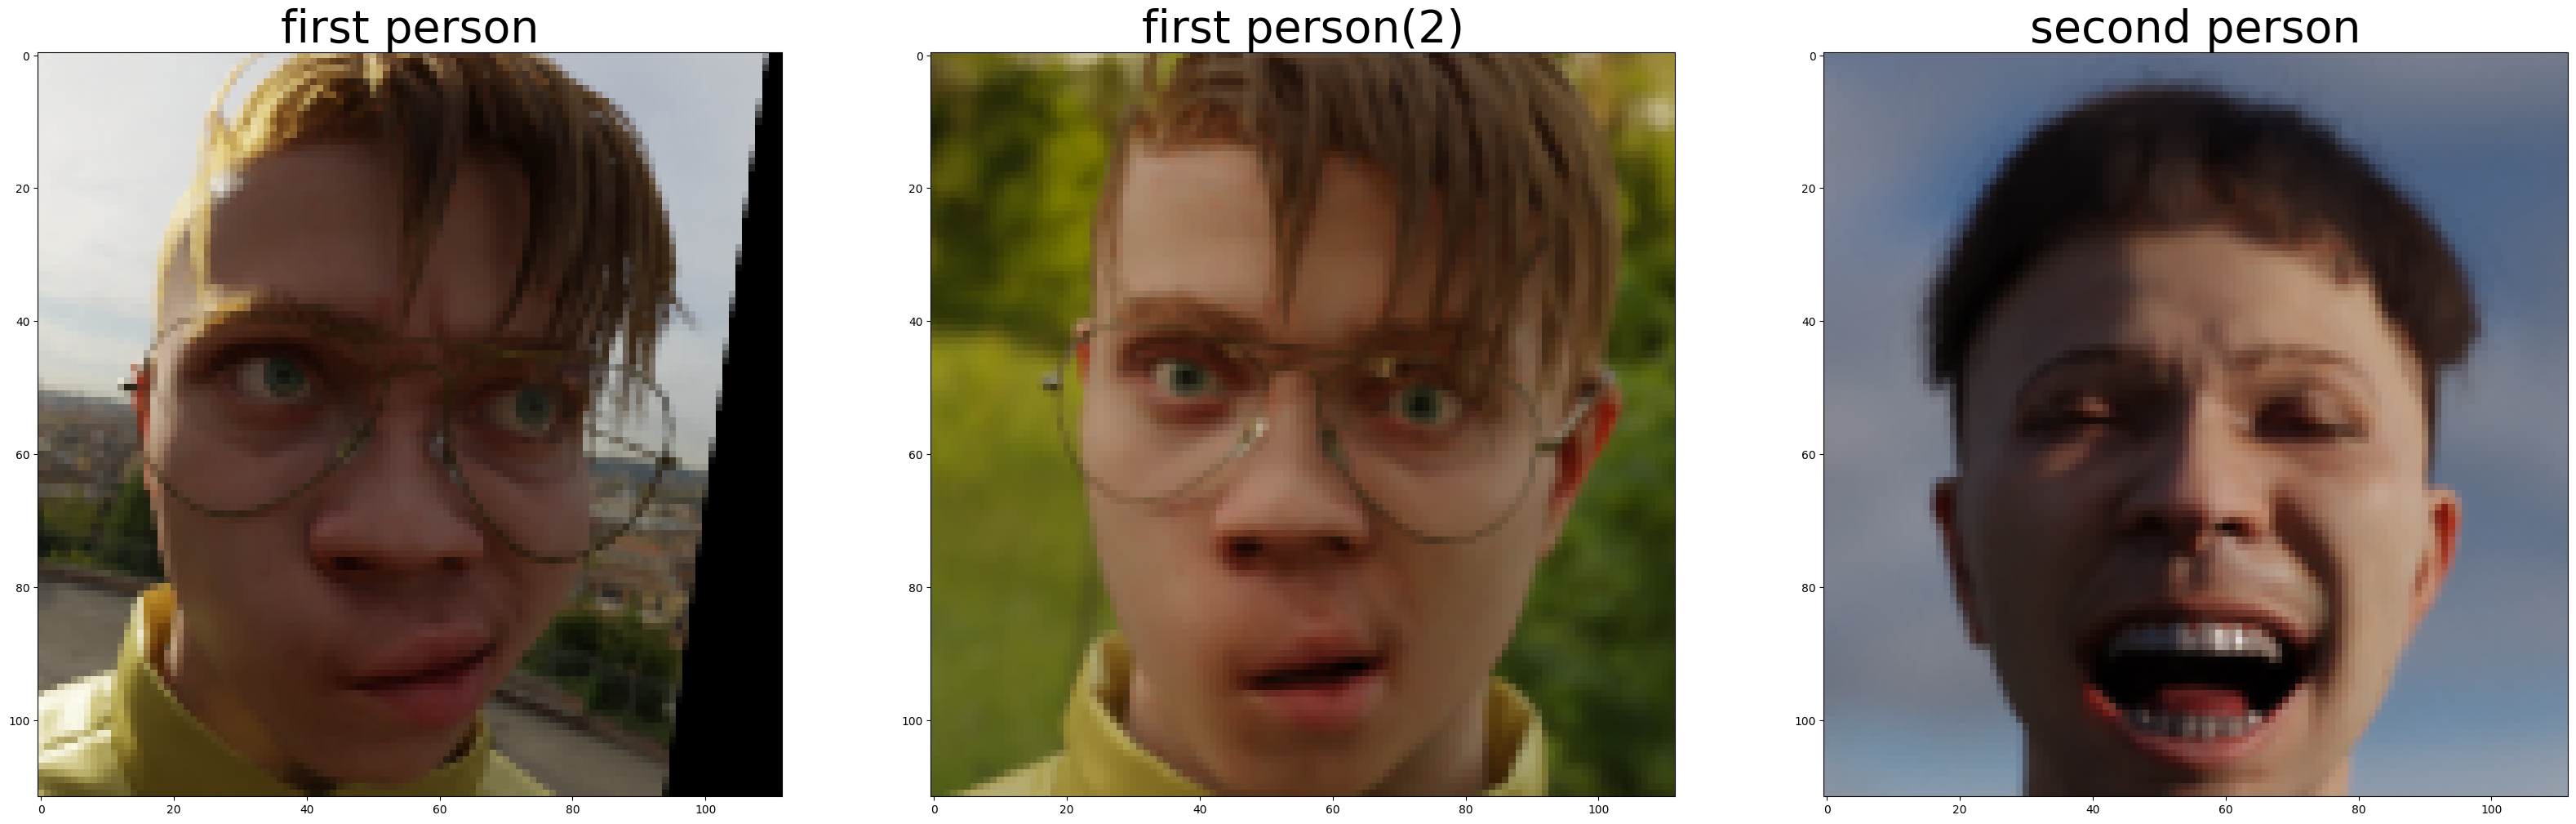

In [5]:
batch = next(iter(train_dataloader))
im11, im12, im21 = batch[:3]
print(im11.shape, im12.shape, im21.shape)
# for im11, im12, im21 in batch:
fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im11.permute(1, 2, 0).numpy())
ax1.set_title("first person")
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im12.permute(1, 2, 0).numpy())
ax2.set_title("first person(2)")
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im21.permute(1, 2, 0).numpy())
ax3.set_title("second person")

for ax in fig.axes:
    ax.title.set_fontsize(40)
plt.show()

In [6]:
model = nn.Sequential( # Input image size = 112 x 112
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 56 x 56
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 28 x 28
    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(48 * 28 * 28, 4096),
    nn.ReLU(),
    nn.Linear(4096, 128),
    nn.ReLU()
)
device = torch.device('cuda')
model = model.to(device)


In [7]:
# Use torchsummary to check model memory usage
import torchsummary as ts
ts.summary(model, (3, 112, 112), batch_size=128 * 3, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [384, 32, 112, 112]             896
       BatchNorm2d-2        [384, 32, 112, 112]              64
              ReLU-3        [384, 32, 112, 112]               0
         MaxPool2d-4          [384, 32, 56, 56]               0
            Conv2d-5          [384, 32, 56, 56]           9,248
       BatchNorm2d-6          [384, 32, 56, 56]              64
              ReLU-7          [384, 32, 56, 56]               0
         MaxPool2d-8          [384, 32, 28, 28]               0
            Conv2d-9          [384, 48, 28, 28]          13,872
      BatchNorm2d-10          [384, 48, 28, 28]              96
             ReLU-11          [384, 48, 28, 28]               0
           Conv2d-12          [384, 48, 28, 28]          20,784
      BatchNorm2d-13          [384, 48, 28, 28]              96
             ReLU-14          [384, 48,

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
class Logger:
    def __init__(self):
        self.losses = []
        self.sim_losses = []
        self.diff_losses = []

    def log_loss(self, loss: torch.Tensor, sim_loss: torch.Tensor, diff_loss: torch.Tensor):
        self.losses.append(loss.item())
        self.sim_losses.append(sim_loss.item())
        self.diff_losses.append(diff_loss.item())

    def get_avg_loss(self, n:int = 1000):
        """"""
        return np.mean(self.losses[-n]), np.mean(self.sim_losses[-1]), np.mean(self.diff_losses[-1])


In [10]:
vec1 = torch.Tensor([1, 2, -1])
vec2 = torch.Tensor([1, 2, -1.1])
vec3 = torch.Tensor([-10, 17, 1])
vecs = [vec1, vec2, vec3]
for i, vec in enumerate(vecs):
    vecs[i] = vec / torch.norm(vec)
vec1, vec2, vec3 = vecs
print(torch.cosine_similarity(vec1, vec2, dim=0), torch.cosine_similarity(vec1, vec3, dim=0))
print(torch.cosine_similarity(torch.stack((vec2, vec1)), torch.stack((vec1, vec3)), dim=1))
torch.stack((vec1, vec2))

tensor(0.9993) tensor(0.4755)
tensor([0.9993, 0.4755])


tensor([[ 0.4082,  0.8165, -0.4082],
        [ 0.4013,  0.8026, -0.4414]])

In [11]:
def loss_fn(vec_sim1: torch.Tensor, vec_sim2: torch.Tensor, vel_dif1: torch.Tensor, alpha: float =2, beta: float =1, logger: Logger = None)->torch.Tensor:
    """
    :param vec_sim1: vector, related to first image of first person
    :param vec_sim2: vector related to second image of first person
    :param vel_dif1: vector related to first image of second person
    :param alpha: similarity coefficient
    :param beta: difference coefficient
    :param logger: Logger object
    :return: torch.Tensor - total Loss
    """
    sim = alpha * ( 1 - torch.abs(torch.cosine_similarity(vec_sim1, vec_sim2, dim=1).mean()))
    dif = beta * torch.abs(torch.cosine_similarity(vec_sim1, vel_dif1, dim=1).mean() + torch.cosine_similarity(vec_sim2, vel_dif1, dim=1).mean())
    total_loss = sim + dif
    if logger is not None:
        logger.log_loss(total_loss, sim, dif)
    return total_loss

In [12]:
logger = Logger()
test_logger = Logger()

In [32]:
for epoch in tqdm(range(5)):
    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = batch.to(device)
        vec = model(batch)
        sim1 = vec[::3]
        sim2 = vec[1::3]
        dif1 = vec[2::3]
        if i % 100 == 0:
            logger_ = logger
        else:
            logger_ = None
        loss = loss_fn(sim1, sim2, dif1, logger=logger)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for el in tqdm(test_dataloader, colour="red"):
            el = el.to(device)
            vec = model(el)
            sim1 = vec[::3]
            sim2 = vec[1::3]
            dif1 = vec[2::3]
            loss = loss_fn(sim1, sim2, dif1, logger=test_logger)
    model.train()

    print(logger.get_avg_loss())
    print(f"Epoch {epoch} test loss: {test_logger.get_avg_loss()} train loss {logger.get_avg_loss()}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1.0753875970840454, 0.6431106328964233, 0.4322769343852997)
Epoch 0 test loss: (0.8655063509941101, 0.5297790765762329, 0.3357272744178772) train loss (1.0753875970840454, 0.6431106328964233, 0.4322769343852997)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.9048607349395752, 0.513668417930603, 0.39119231700897217)
Epoch 1 test loss: (0.9914566278457642, 0.48755109310150146, 0.5039055347442627) train loss (0.9048607349395752, 0.513668417930603, 0.39119231700897217)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.9634147882461548, 0.5985541343688965, 0.3648606538772583)
Epoch 2 test loss: (0.44006919860839844, 0.38575422763824463, 0.054314985871315) train loss (0.9634147882461548, 0.5985541343688965, 0.3648606538772583)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1.0634135007858276, 0.578429102897644, 0.4849843978881836)
Epoch 3 test loss: (1.2623505592346191, 0.8303197622299194, 0.4320307970046997) train loss (1.0634135007858276, 0.578429102897644, 0.4849843978881836)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.9473278522491455, 0.5766458511352539, 0.3706819713115692)
Epoch 4 test loss: (0.9276502728462219, 0.5326822996139526, 0.3949679732322693) train loss (0.9473278522491455, 0.5766458511352539, 0.3706819713115692)


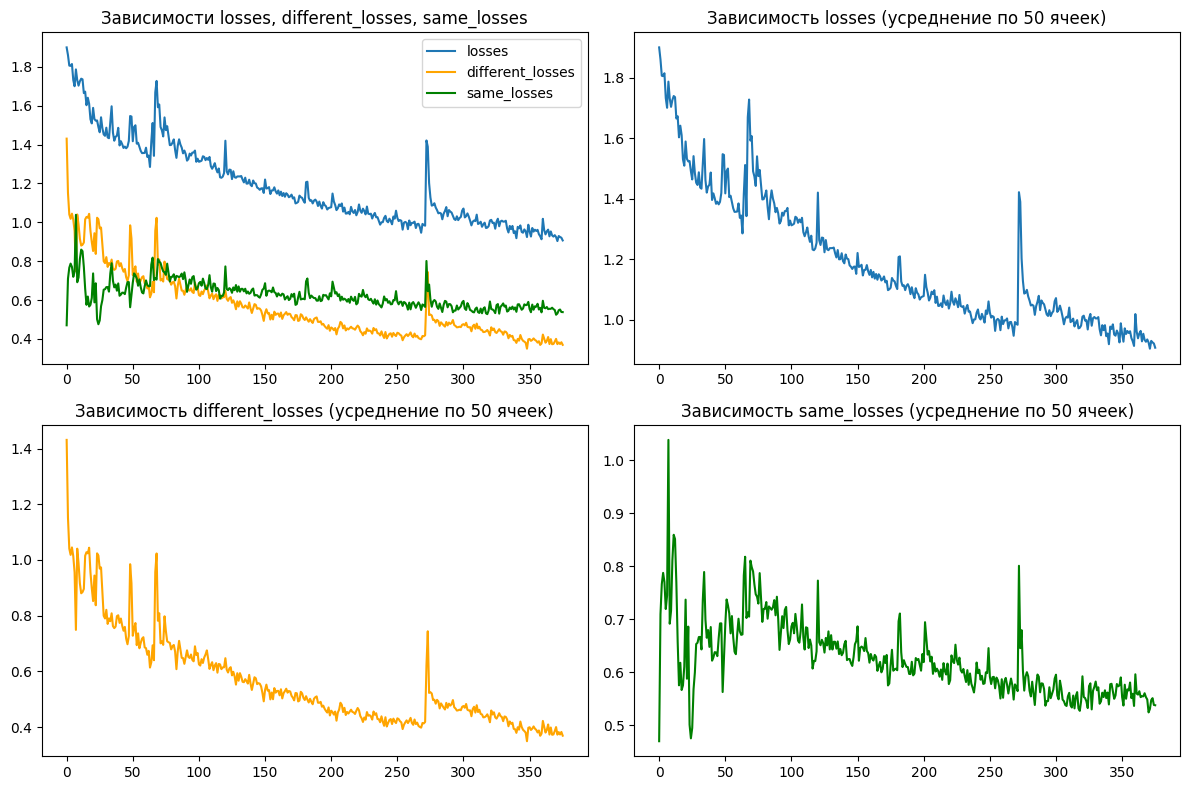

In [35]:
# Грифи для трэин лоса
# Усредняем каждые 50 ячеек
losses, different_losses, same_losses = logger.losses, logger.diff_losses, logger.sim_losses
N = len(losses)
avgk = 50
losses_avg = [np.mean(losses[i:i+avgk]) for i in range(0, N, avgk)]
different_losses_avg = [np.mean(different_losses[i:i+avgk]) for i in range(0, N, avgk)]
same_losses_avg = [np.mean(same_losses[i:i+avgk]) for i in range(0, N, avgk)]

# Создаем фигуру и оси графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Зависимости losses, differ
# ent_losses, same_losses от индекса на одном графике
axs[0, 0].plot(losses_avg, label='losses')
axs[0, 0].plot(different_losses_avg, color='orange', label='different_losses')
axs[0, 0].plot(same_losses_avg, color='green', label='same_losses')
axs[0, 0].set_title('Зависимости losses, different_losses, same_losses')
axs[0, 0].legend()

# Зависимость losses от индекса
axs[0, 1].plot(losses_avg)
axs[0, 1].set_title('Зависимость losses (усреднение по 50 ячеек)')

# Зависимость different_losses от индекса
axs[1, 0].plot(different_losses_avg, color='orange')
axs[1, 0].set_title('Зависимость different_losses (усреднение по 50 ячеек)')

# Зависимость same_losses от индекса
axs[1, 1].plot(same_losses_avg, color='green')
axs[1, 1].set_title('Зависимость same_losses (усреднение по 50 ячеек)')

# Отображаем графики
plt.tight_layout()
plt.show()

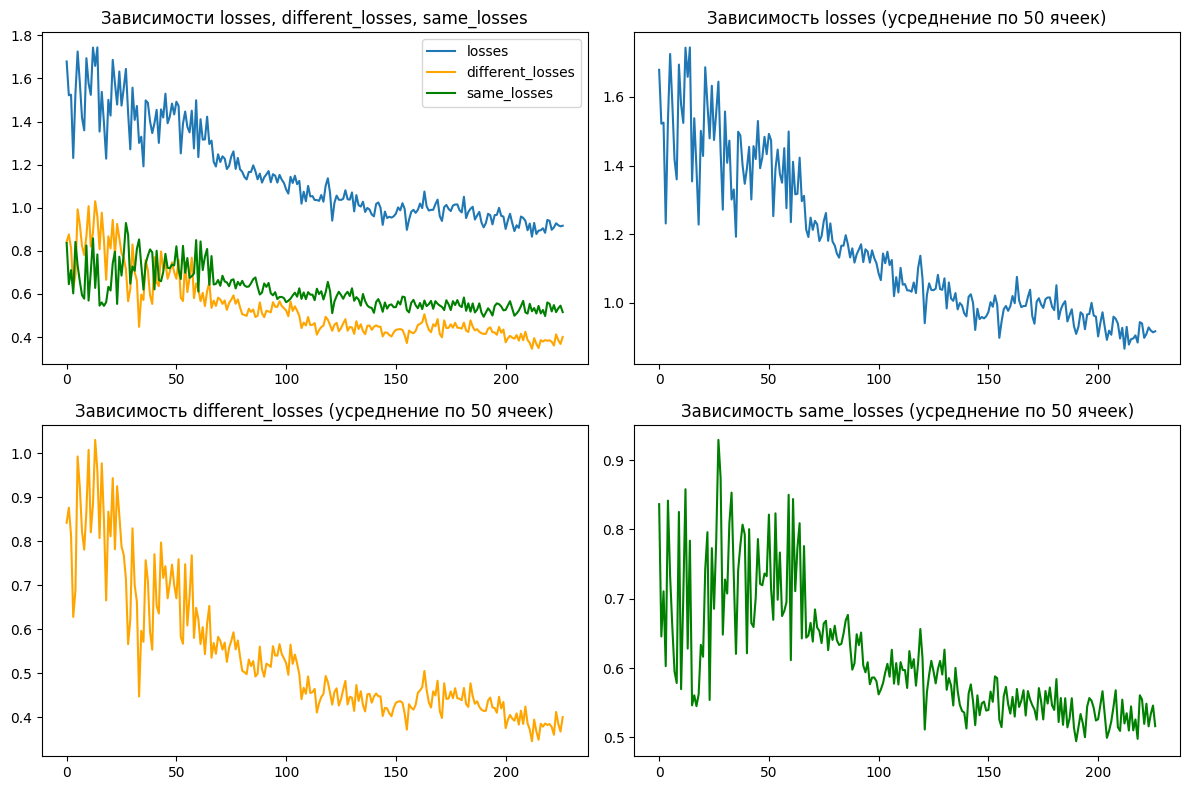

In [36]:
# Грифи для тест лоса
# Усредняем каждые 50 ячеек
losses, different_losses, same_losses = test_logger.losses, test_logger.diff_losses, test_logger.sim_losses
N = len(losses)
avgk = 75
losses_avg = [np.mean(losses[i:i+avgk]) for i in range(0, N, avgk)]
different_losses_avg = [np.mean(different_losses[i:i+avgk]) for i in range(0, N, avgk)]
same_losses_avg = [np.mean(same_losses[i:i+avgk]) for i in range(0, N, avgk)]

# Создаем фигуру и оси графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Зависимости losses, differ
# ent_losses, same_losses от индекса на одном графике
axs[0, 0].plot(losses_avg, label='losses')
axs[0, 0].plot(different_losses_avg, color='orange', label='different_losses')
axs[0, 0].plot(same_losses_avg, color='green', label='same_losses')
axs[0, 0].set_title('Зависимости losses, different_losses, same_losses')
axs[0, 0].legend()

# Зависимость losses от индекса
axs[0, 1].plot(losses_avg)
axs[0, 1].set_title('Зависимость losses (усреднение по 50 ячеек)')

# Зависимость different_losses от индекса
axs[1, 0].plot(different_losses_avg, color='orange')
axs[1, 0].set_title('Зависимость different_losses (усреднение по 50 ячеек)')

# Зависимость same_losses от индекса
axs[1, 1].plot(same_losses_avg, color='green')
axs[1, 1].set_title('Зависимость same_losses (усреднение по 50 ячеек)')

# Отображаем графики
plt.tight_layout()
plt.show()

# Data validating


In [ ]:
val_dataset = FaceFolderDataset()